In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### Data Loading

In [2]:
train_df = pd.read_csv('train.csv', index_col='PassengerId')
pd.set_option('display.max_columns', None)

In [3]:
train_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


### Charts

#### Age

In [54]:
train_df['Survived'].groupby(pd.qcut(train_df['Age'],5)).mean()

C:\Users\Kirisa\AppData\Local\Temp\ipykernel_17328\3914831692.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train_df['Survived'].groupby(pd.qcut(train_df['Age'],5)).mean()


Age
(0.419, 19.0]    0.481707
(19.0, 25.0]     0.328467
(25.0, 31.8]     0.393701
(31.8, 41.0]     0.437500
(41.0, 80.0]     0.373239
Name: Survived, dtype: float64

#### Sex

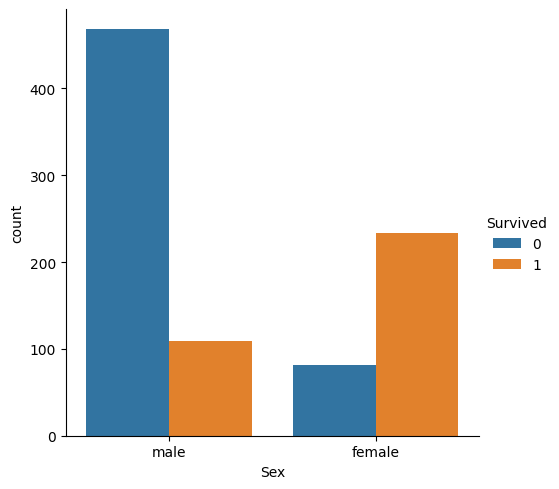

In [5]:
sns.catplot(data=train_df, x='Sex', kind='count', hue='Survived')
plt.show()

#### Pclass

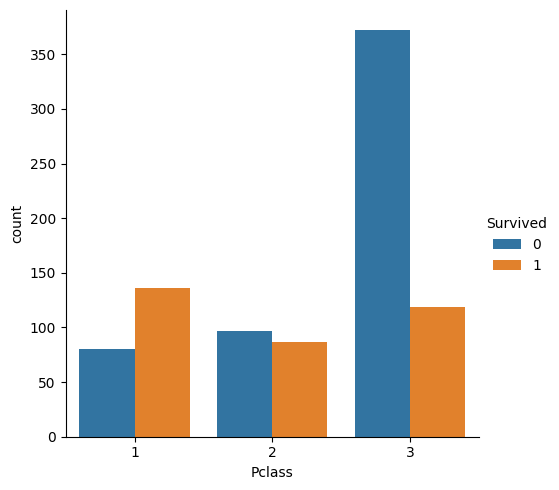

In [6]:
sns.catplot(data=train_df, x='Pclass', kind='count', hue='Survived')
plt.show()

#### Embraked

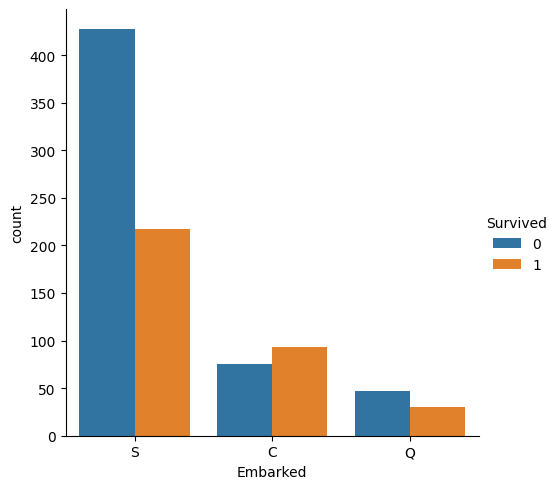

In [7]:
sns.catplot(data=train_df, x='Embarked', kind='count', hue='Survived')
plt.show()

### Feature Engineering

Drop column: Cabin, Ticket, Name. Column Survived is our goal. \
Create new column as FamilySize: sum of values columns SibSp and Parch
Categorical columns: Pclass, Sex, FamilySize, Embarked \
Numeric columns: Age, Fare \
Non null values will be replaced with const for categorical columns and average value to numeric columns

In [8]:
train_df['FamilySize'] = np.where(train_df['SibSp'] + train_df['Parch'] == 0, 'Solo', np.where(train_df['SibSp'] + train_df['Parch'] <= 3, 'Middle', 'Big'))

In [9]:
features_num = ['Age', 'Fare']
features_cat = ['Pclass', 'Sex', 'FamilySize', 'Embarked']

In [10]:
train_df.drop(columns=['Name', 'Ticket', 'Cabin', 'SibSp', 'Parch'], inplace=True)

In [11]:
X = train_df.copy()
y = X.pop('Survived')

In [12]:
train_df

,Survived,Pclass,Sex,Age,Fare,Embarked,FamilySize
PassengerId,,,,,,,
1,0,3,male,22.0,7.2500,S,Middle
2,1,1,female,38.0,71.2833,C,Middle
3,1,3,female,26.0,7.9250,S,Solo
4,1,1,female,35.0,53.1000,S,Middle
5,0,3,male,35.0,8.0500,S,Solo
...,...,...,...,...,...,...,...
887,0,2,male,27.0,13.0000,S,Solo
888,1,1,female,19.0,30.0000,S,Solo
889,0,3,female,NaN,23.4500,S,Middle


### Data Cleaning and Encoding

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

Create pipelines for clean and encoding data

In [14]:
transformer_num = make_pipeline(
    SimpleImputer(strategy="mean"),
    StandardScaler(),
)

transformer_cat = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(handle_unknown='ignore'),
)

preprocessor = make_column_transformer(
    (transformer_num, features_num),
    (transformer_cat, features_cat)
)

Split data and apply our pipeline

In [15]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, stratify=y, test_size=0.75)

X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)

### DecisionTree model

In [16]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [17]:
model1 = DecisionTreeClassifier(random_state=1)

In [18]:
model1.fit(X_train, y_train)

DecisionTreeClassifier(random_state=1)

In [19]:
predictions = model1.predict(X_valid)

In [20]:
model_score = accuracy_score(y_valid, predictions)
model_score

0.750373692077728

### RandomForest model

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [22]:
model2 = RandomForestClassifier(criterion='gini',n_estimators=700, random_state=1)

In [23]:
model2.fit(X_train, y_train)

RandomForestClassifier(n_estimators=700, random_state=1)

In [24]:
predictions = model2.predict(X_valid)

In [25]:
model_score = accuracy_score(y_valid, predictions)
model_score

0.772795216741405

### XGBoost model

In [26]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

In [27]:
model3 = XGBClassifier(n_estimators=1000, learning_rate=0.05, random_state=1)

In [28]:
model3.fit(X_train, y_train, 
             early_stopping_rounds=5, 
             eval_set=[(X_valid, y_valid)], 
             verbose=False)

C:\Users\Kirisa\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, random_state=1, ...)

In [29]:
predictions = model3.predict(X_valid)

In [30]:
model_score = accuracy_score(y_valid, predictions)
model_score

0.8176382660687593